##  GreenBuildings3: Deploying Models With MLflow, Docker & Google App Engine

------

## Contents

__[1. Introduction](#intro)__

__[2. Intro To MLflow](#mlflow-one)__

__[3. Linear Regression & Logging A Simple Run](#mlflow-two)__

__[4. XGBoost & Logging Nested Runs for GridSearchCV](#mlflow-three)__

__[5. MLflow Models: Model Serving With REST APIs](#mlflow-four)__

__[6. Deploying to Google App Engine with Docker](#mlflow-five)__

__[7. Conclusions ](#fifth-bullet)__


--------------

## Introduction <a class="anchor" id="intro"></a>
-------------


This is the third and final post in a series of blog posts about energy usage and green house gas emissions of buildings in New York City. In the [first post](http://michael-harmon.com/blog/GreenBuildings1.html) I covered exploratory data analysis and outlier removal.  In the [second post](http://michael-harmon.com/blog/GreenBuildings2.html) I covered imputing missing values. These topics make up the majority of what is called "data cleaning".  This last post will deal with model building and model deployment. Specifically I will build a model of New York City building green house gas emissions based on the building energy usage metrics. After I build a sufficiently accurate model I will convert the model to REST API for deployment.

These processes of model development and deployment are made a lot easier with [MLflow](https://mlflow.org/) library. I will use the [MLflow Tracking](https://www.mlflow.org/docs/latest/tracking.html) framework to log all the diffent models I developed and their performance.  This acts a great way to memorialize the development process. I will then use the [MLflow Models](https://www.mlflow.org/docs/latest/models.html) to convert my model into a [REST API](https://restfulapi.net/) as a way of model serving and deployment. I will go over two ways MLflow Models creates REST API including the newly added way which uses [Docker](https://www.docker.com/).

Note the MLflow library is still *relatively new* and the APi may change, for this purpose I should remark that I am working with MLflow version 1.8.0.

## Working With MLflow <a class="anchor" id="mlflow-one"></a>
-----------------

[MLflow](https://mlflow.org/) is an open source tool to make machine learning easier and more reproduciable made by [Databricks](https://databricks.com/) (the same people who created [Apache Spark](https://spark.apache.org/)).  There are many components to MLflow, but the two I will be looking at are,

- MLflow Tracking : A tool for logging modeling experiments
- MLflow Models : A tool for serving models as REST APIs

I will stick to using MLflow locally instead of a production set up. You can start the Web UI with the command:

    mlflow ui --host=0.0.0.0 --port=5050

Then going to the website http://0.0.0.0:5050 in your web broswer where we will see the following:


![image.png](images/EmptyMLFlow.png)


We can see the generic MLflow website without any modeling experiment data. This will change soon enough. We can collect modeling information into "*experiments*" that will contain "*runs*", i.e. information on builds of models. Each run could be one model or a series of different model each trained with different parameter values.  In this way MLflow tracking is great for organizing and maintaining as much information about model development as you like.  

Locally, MLflow will create a file directory called,

    mlruns
    
that will be housed in the same path that the `mlflow ui` was run in.

Let's get into more of the details on MLflow and import it along with some other basic libraries:

In [1]:
import mlflow
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

We can see what the mlflow tracking url is to see where all the data for MLflow will be stored (i.e. where `mlruns` directory is):

In [2]:
mlflow.get_tracking_uri()

'file:///Users/mukeharmon/Documents/DS_Projects/NYCEnergyUsage/notebook/mlruns'

Now let's create an experiment for this project and get started!  

In [3]:
try:
    mlflow.create_experiment("greenbuildings")
    experiment = mlflow.get_experiment_by_name("greenbuildings")
except:
    experiment = mlflow.get_experiment_by_name("greenbuildings")

We can see that we get an "experiment" that has a number of attributes:

In [4]:
print(experiment)

<Experiment: artifact_location='file:///Users/mukeharmon/Documents/DS_Projects/NYCEnergyUsage/notebook/mlruns/1', experiment_id='1', lifecycle_stage='active', name='greenbuildings', tags={}>


These attributes include:

- **artifact_location** (where the metadata + models will be stored)
- **experiment_id** (to help us track the experiment)
- **lifestyle_stage** (whether its active, deleted, etc.)
- **name**
- **tag**


The `experiment_id` is an important attribute and will be used quite frequently to know where to log and organize all the modeling information. Let's set that number as a variable as its own to use later:

In [5]:
exp_id = experiment.experiment_id

Let's move on to building our first model for predicting green house gas emission of buildings and create an rest API out of it.

## Linear Regression & Logging A Simple Run <a class="anchor" id="mlflow-two"></a>

Let's build a predictive model for green house gas emissions by multifamily homes and offices  in New York City.  We'll do this at first using a simple linear regression model.  While not the best in terms of predictive performance it is often a best first step since it allows us to interpet the effect each feature has on the predicted green house gas emissions.  We'll discuss this more later, but for now lets import our data from [Google BigQuery](https://cloud.google.com/bigquery) using the set up from the [previous posts](http://michael-harmon.com/blog/GreenBuildings1.html):

In [1]:
from google.oauth2 import service_account
from google.cloud import bigquery
import json
import pandas_gbq 


credentials = service_account.Credentials\
                             .from_service_account_file('./derby.json')

pandas_gbq.context.credentials = credentials
pandas_gbq.context.project     = credentials.project_id

In [2]:
df = pandas_gbq.read_gbq("""
SELECT  
    CAST(Energy_Star AS INT64) AS Energy_Star,
    Site_EUI,
    NGI,
    EI,
    GHGI,
    CAST(Residential AS INT64) AS Residential,
FROM 
    db_gb.clean_data
""")

Downloading: 100%|██████████| 9542/9542 [00:01<00:00, 5514.63rows/s]


And get the target variable and predictors:

In [3]:
X = df.drop("GHGI",axis=1)
Y = df["GHGI"] 

Let's remind ourselves what the distribution of the target variable and predictors look like using the pairplot shown in the [last post](http://michael-harmon.com/blog/GreenBuildings2.html):

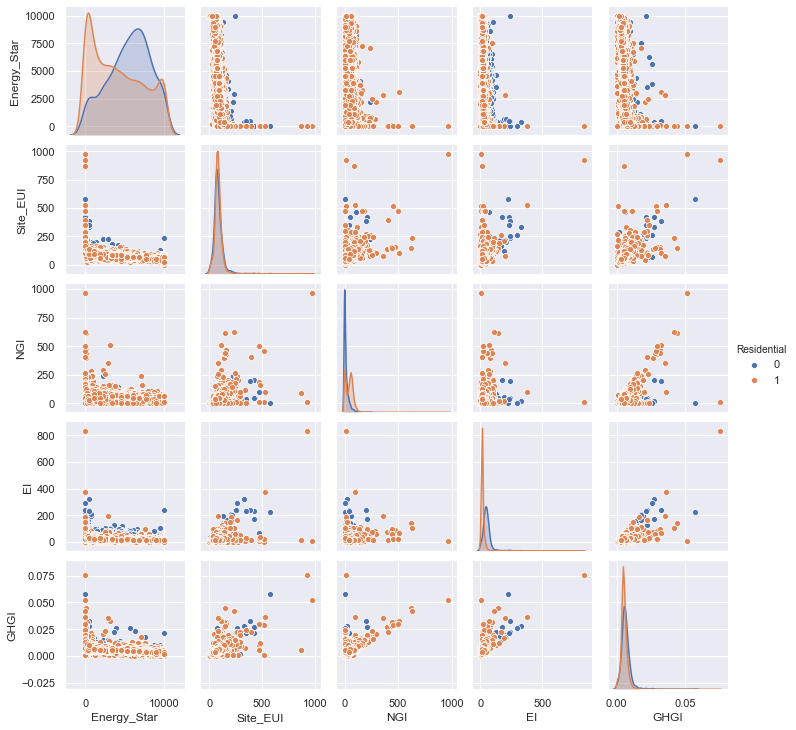

In [9]:
sns.pairplot(df,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             size=2,
             hue='Residential')

**We can from the last row in this graph that the relationship between `GHGI` and `Site_EUI`, `NGI`, as well as `EI` is somewhat linear, but the relationship of `GHGI` and `Energy_Star` is less well defined.**

Let's create our train and test set as well fix our random state (to have repeatable datasets)

In [4]:
from sklearn.model_selection import train_test_split

random_state = 93

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

As we stated earlier we'll start out with a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">Linear Regression Model</a> since it is simple and interpertable. We can easily implement a least squares regression model using Scikit-learn:

In [11]:
from sklearn.preprocessing   import StandardScaler
from sklearn.pipeline        import Pipeline
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import r2_score, mean_squared_error

pipe = Pipeline([('scaler',StandardScaler()), 
                 ('reg', LinearRegression())])

model = pipe.fit(X_train, y_train)

We can then evaluate the model performance ($R^{2}$-score) on the test set to *see how much variance in the model we are able to explain* as well as the mean square error (MSE):

In [12]:
y_pred = model.predict(X_test)

print("R2 score: {}".format(r2_score(y_test, y_pred)))
print("MSE: {}".format(mean_squared_error(y_test, y_pred)))

R2 score: 0.6476491751039196
MSE: 2.2264594213905994e-06


We can explain 64.76% of the variance which is pretty good, but definitely leaves room for improvement.  Let's take a look at the coefficients of the linear regression model.

In [13]:
# get the last stage of the pipeline which is the model
reg = pipe.steps[1][1]

# print the coefficients
for coef in zip(X_train.columns, reg.coef_):
    print(coef)

('Energy_Star', -0.00012438019591537333)
('Site_EUI', 0.00163961529817878)
('NGI', 0.0002444723997324787)
('EI', 0.001016531188328767)
('Residential', 8.968370025022292e-05)


The model coefficents tell us that features that have continuous feautres an increase in one of their in units results in an increase in the unit of green house emissions that is equal to the coefficent.  We can see that increasing the electricty, energy intensity , and natural gas intensity increases green house gas emissions which makes sense.  Increasing the Energy Star rating of the building tends to decrease the greenhouse gas emissions which makes sense. It also seems that residential buildings tend to emit more green house gases than office space buildings, albiet weakly.

We can measure the p-values for coefficents by using Scikit-Learns's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html">f_regression</a> function.

In [14]:
from sklearn.feature_selection import f_regression

f_stats, pvals = f_regression(X_train, y_train)

for coef in zip(X_train.columns, pvals):
    print("{0}'s p-value : {1}".format(coef[0],coef[1]))

Energy_Star's p-value : 0.0
Site_EUI's p-value : 0.0
NGI's p-value : 1.9403675290317854e-183
EI's p-value : 0.0
Residential's p-value : 6.7888853905324595e-28


**We see that even though the coeficients of the regression model are rather small, their small p-values signifiy that they are still signifcant and should be included in our model.**  Overfitting a linear model can be quite obvious from the coefficients when one of the features has a large absolute value. In our model this does not seem to be the case and we don't have to consider overfitting or using regularization further.

Let's add a run to the MLflow experiment that corresponds to this model.  We use the `start_run` function and pass the experiment id along with the name for this run being "Linear Regression"

In [15]:
run = mlflow.start_run(experiment_id=exp_id, run_name="Linear Regression")

We can see that we have an active run that is a [RunInfo](https://www.mlflow.org/docs/latest/python_api/mlflow.entities.html#mlflow.entities.RunInfo) entity that maintains information about the run:

In [16]:
run.info

<RunInfo: artifact_uri='file:///Users/mukeharmon/Documents/DS_Projects/NYCEnergyUsage/notebook/mlruns/1/835633c6abc4436ea913f471a123e729/artifacts', end_time=None, experiment_id='1', lifecycle_stage='active', run_id='835633c6abc4436ea913f471a123e729', run_uuid='835633c6abc4436ea913f471a123e729', start_time=1587943715502, status='RUNNING', user_id='mukeharmon'>

In [17]:
artifact_uri = run.info.artifact_uri

We can add the metrics for our model using the add_metrics

In [18]:
mlflow.log_metric("r2" ,r2_score(y_test, y_pred))
mlflow.log_metric("mse", mean_squared_error(y_test, y_pred))

Let's look at some of the residuals in the continuous features to see if we can find any non-linear patterns that might signal ways improve the model.

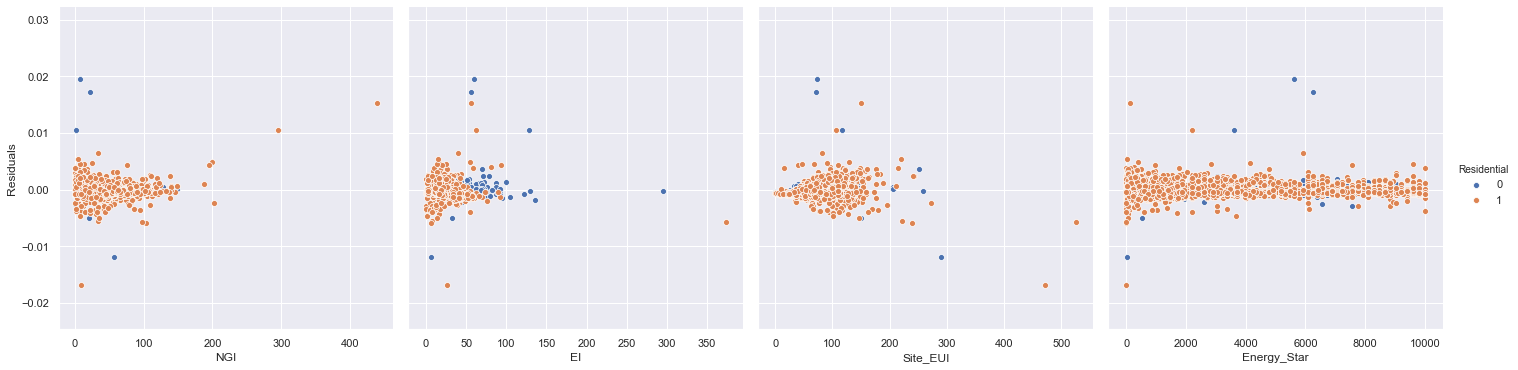

In [19]:
from Plotting_Functions import plot_residuals

f = plot_residuals(X_test = X_test,
                   y_test = y_test,
                   y_pred = y_pred)

There are no obvious patterns in the residuals, but at the same time they **do not appear to be normally distributed as the theory says they should be.**  This tells me that we might be able to use a more flexible model to capture the nonlinearities in the relationships.

We can log this image as well using the `log_artifact` method:

In [20]:
f.savefig("resid.png")
mlflow.log_artifact("resid.png")

For the time being let's log the model using the so called [scikit-learn flavor](https://mlflow.org/docs/latest/models.html#scikit-learn-sklearn) and end the run:

In [21]:
import mlflow.sklearn
mlflow.sklearn.log_model(model, "LinearModel")
mlflow.end_run()

We can go to the mlflow web UI to see that the run has been added with its metrics:
![image.png](images/LinearModel1.png)

Clicking on the run we can see model performance metrics, logged model and artifacts:

![image.png](images/LinearModel2.png)

The `LinearModel` folder under the artifacts tab contains the [conda environment](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) (`conda.yml`) used to build the model, the pickled model (`model.pkl`) and associated metadata (`MLModel`).  We will use a similar folder later for model serving.  We should note that the model `conda.yml` file is used to package all the necessary libraries for serving the model `model.pkl`.

Let's move on to a more flexible model and hopefully improve our predictions.

##  XGBoost & Logging Nested Runs for GridSearchCV <a class="anchor" id="mlflow-three"></a>

Let's try another model to see if we cant improve our $R^2$ score and MSE for our model. One model that performs quite well is [XGBoost](https://xgboost.readthedocs.io/en/latest/).  XGBoost is a nonlinear model based on decision trees using gradient boosting and is one of the best performing machine learning models avaiable. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function. You can read more about gradient boosting [here](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)


Let's import our XGBoost Regressor and then run a small grid search using cross-valiation to find the optimal parameter values for our model:

In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# define the parameter values
paramters = {"n_estimators"   :[10,15,25,50,100,150],
             "max_depth"      :[3,5,7,10],
             "loss"           :["ls", "lad"]
}

# defind the grid search and optimization metric
grid = GridSearchCV(estimator=XGBRegressor(),
                    param_grid=paramters,
                    scoring="r2",
                    cv=5,
                    n_jobs=-1)

# perform the grid search
xgb_model = grid.fit(X_train, y_train)

Now that we have the best model from our grid search over the trainin set let see how it performs on the test set:

In [25]:
y_pred = xgb_model.predict(X_test)

print("R^2 score: {}".format(r2_score(y_test, y_pred)))
print("MSE {}".format(mean_squared_error(y_test, y_pred)))

R^2 score: 0.7761477343001326
MSE 1.4144935977206672e-06


A definite improvement in the $R^2$ score and MSE! 

Let's take a look at the residuals:

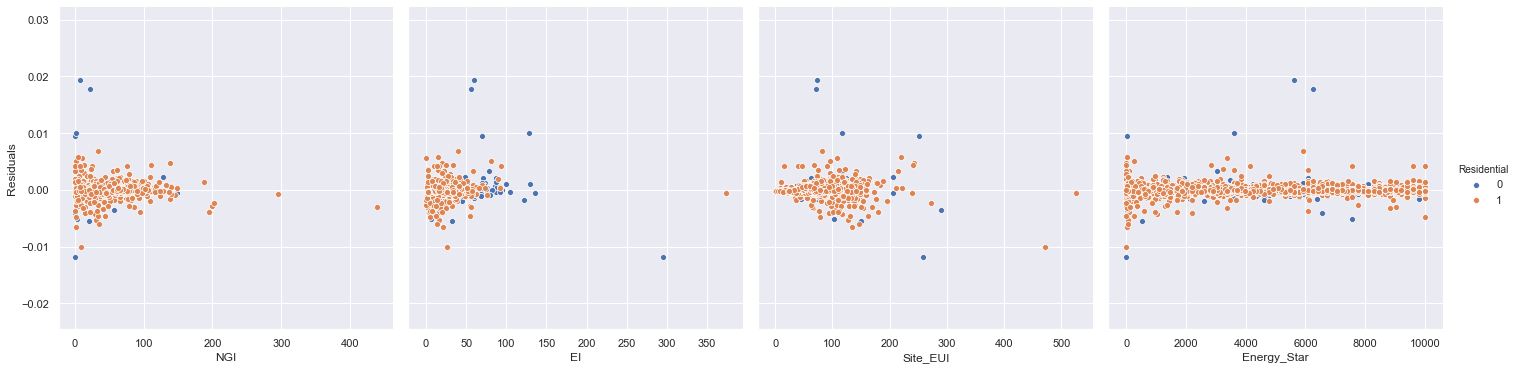

In [29]:
f = plot_residuals(X_test = X_test,
                   y_test = y_test,
                   y_pred = y_pred)

f.savefig("resid.png")

Not terribly different than the linear regression model, but we see less outliers in the relationship between `NGI` and the residuals. 


While we have improved our prediction capabilities, one draw back to more complex models like Gradient Boosted Regressors is that they are less interperable. Despite this draw back, XGBoost still allows to the find the relative importance of the features on the outcome of the model:

In [30]:
model = grid.best_estimator_
for coef in zip(X_train.columns, model.feature_importances_):
    print(coef)

('Energy_Star', 0.03286382)
('Site_EUI', 0.4422697)
('NGI', 0.26643634)
('EI', 0.24186888)
('Residential', 0.016561199)


Notice that the sum of the importance of these features is 1 and the most important feature is `Site_EUI` which was the feature with the largets coefficent in the Linear Regression Model.  While we know the importance of the features we don't now how they effect the `GHGI`, i.e. if the `NGI` does the `GHGI` go up or down?  By how much does it go up or down?  Given what we see just from the above these are not questions the model can answer in general terms. This is what we mean by model interperability!


Now let's log all the information from the grid search and each of the models performances using a nested run:

In [28]:
with mlflow.start_run(
            experiment_id=exp_id,
            run_name="XGBoostRegressor",
            nested=True
):
    # Get the grid cell results
    cv_results = grid.cv_results_

    # loop over each of the parameters and log them along
    # with the metric and modle rank
    for params, metric, rank in zip(cv_results['params'],
                                    cv_results['mean_test_score'],
                                    cv_results["rank_test_score"]):
        
        with mlflow.start_run(experiment_id=exp_id, 
                              nested=True):
            # log the parameters
            mlflow.log_params(params)
            
            # log the R2 score
            mlflow.log_metric("r2",metric)
            
            # set the rank
            mlflow.set_tag("rank",rank)
            
    # For the best estimator (xbg_model) 
    # lets log the parameters for the best model and
    # its metric artifacts
    mlflow.log_params(grid.best_params_)
    mlflow.log_metrics({"r2":r2_score(y_test, y_pred),
                       " mse":mean_squared_error(y_test, y_pred)})
    
    mlflow.log_artifact("resid.png")
    mlflow.log_model("XGBoost",xbg_model)

Let's take a look at the ML-flow UI:

![image.png](images/XGBoostRun.png)

We can see the + symbol on the left side of the `Run Name` corresponding to the run "XGBoostRegresor".  Clicking on the symbol shows the rest of the results from the grid search as seen below:

![image.png](images/XGBoostGrid.png)

We can see the different parameters used in each of the runs, the $R^2$ value for that model as well as the ranking of that model. Notice that the first model and the last of the models with rank 1 are the same. However, their $R^2$ values are different. This is because the one is the model perfomance on the test set, while the other is the average model of the model performances in the 5-fold cross validation.

## MLflow Models: Serving With REST APIs & Docker<a class="anchor" id="mlflow-four"></a>

Now that we have built a decent model for green house gas emission and we want to deploy this model.  One great way to deploy or serve model is using an [REST API](https://restfulapi.net/). Deploying a model as an API means that we create a [webserver](https://en.wikipedia.org/wiki/Web_server) with a [url](https://en.wikipedia.org/wiki/URL) that accepts requests.  End users or clients can make requests to the API that pass a list of data points containing features usually as [json](https://www.json.org/json-en.html).  This list of features is fed to the model and the spits out a list of predictions corresponding to those features and these are sent back to the client, again usually as json. Deploying a model in this fashion has a number of advantages, one of the top being that you deploying retrained models is invisible to the end user.

In [38]:
import mlflow.xgboost

mlflow.xgboost.save_model(xgb_model, "XGBModel")

Let's now use the MLflow commnand line to serve the model. From the directory where we saved the above model we can use the command:

    mlflow models serve --m XGBModel

This will initially show the following:

![image.png](images/XGBoostServe1.png)

If everything builds properly we will then see the following:

![image.png](images/XGBoostServe1_P2.png)

Notice the "Listening at: http://127.0.0.1:5000", this is the url we will make request to get model predictions.  We have built a REST API that uses [flask](https://flask.palletsprojects.com/en/1.1.x/) and [gunicorn](https://gunicorn.org/) in one line with MLflow!  To see how difficult that be to do by hand see this [write up](https://www.digitalocean.com/community/tutorials/how-to-serve-flask-applications-with-gunicorn-and-nginx-on-ubuntu-18-04).

Now lets test it out!  Let's get some test data:

In [5]:
test_df = X_test.head(2)
test_df

,Energy_Star,Site_EUI,NGI,EI,Residential
3208,7744,52.7,45.964180,10.120456,1
103,9,112.2,25.918749,29.770710,1


We can see what the predictions would be with the xgboost model we have built to compare it to what the REST API returns:

In [40]:
xgb_model.predict(test_df)

array([0.00314277, 0.00720516], dtype=float32)

Now let's convert the test data from a Pandas dataframe to json:

In [7]:
test_json = test_df.to_json(orient='split')
test_json

'{"columns":["Energy_Star","Site_EUI","NGI","EI","Residential"],"index":[3208,103],"data":[[7744,52.7,45.9641802469,10.1204555556,1],[9,112.2,25.9187489356,29.7707095517,1]]}'

Now let's submit a request for predictions to the REST API:

In [10]:
import requests

result = requests.post(url="http://127.0.0.1:5000/invocations",
                       data=test_json,
                       headers={'Content-Type':'application/json'})

In [11]:
result.json()

[0.0031427741050720215, 0.007205158472061157]

The results are the same! Now let's take this one step further. Let's use MLflow to build a [Docker](https://www.docker.com/) image so that we can deploy our REST API using a container. This again, is only one line!  The command is,
    
    mlflow models build-docker -m XGBModel -n xgbmodel
    
Where the `xgbmodel` is the tag for the image. If everythign is built properly we can see the following:

![image.png](images/success.png)

We can see that the image is `fafed3745d54` and the tag is `xgbmodel:latest`. We can then start up our model using the command:

    docker run -ip 8000:8080 fafed3745d54
    
Where we have to use the -p command for [port forwarding](https://runnable.com/docker/binding-docker-ports). Notice that we have to use 8000 because the the results show:

![image.png](images/DockerRun.png)

We can the make a request to that url:

In [61]:
result = requests.post(url="http://127.0.0.1:8000/invocations",
                       data=test_json,
                       headers={'Content-Type':'application/json'})

result.json()

[0.0031427741050720215, 0.007205158472061157]

The reults are the same as expected!

There is one downside for using MLflow to build a docker image in this way is that your image turns out to be quite massive.  We can see this from the command:

    docker images 
    
which shows,

![image.png](images/DockerImageSize.png)

that our model takes up 2.72 GB!  

## 6. Deploying to Google App Engine with Docker  <a class="anchor" id="mlflow-five"></a>

Now lets say want to deploy our Model as REST API on the cloud. We can easily deploy this to [Google Cloud App](https://cloud.google.com/appengine) Engine using the Docker image we created. 


The first step is to follow the instructions [here](https://cloud.google.com/container-registry/docs/quickstart) for copying the image to [Google Cloud Registry (GCR)](https://cloud.google.com/container-registry). For me the command was :

![image](images/pushtogcr.png)

Once that is done we can check GCR to make sure the image has been pushed, I did this below:

![image](images/GCR.png)

I think built out the `app.yaml` for a flexibly environment as described [here](https://cloud.google.com/appengine/docs/flexible/custom-runtimes/build).  The contents of my `app.yaml` are:

    runtime: custom
    env: flex
    service: xgbmodel
    env_variables: 
      DISABLE_NGINX: "true"
      
      
Then I ran the command to deploy the app (`gcloud app deploy`) using `--image-url` with the address for my image in GCR:

![image](images/deploy.png)


One everything is completed I can check my app was created in the App Engine tab:

![image.png](images/AppEngine.png)

Now I can use the `target url` as pictured above to run a request against as show below:

In [16]:
target_url = "https://xgbmodel-dot-advance-sonar-232016.uc.r.appspot.com/invocations"

result = requests.post(url     = target_url,
                       data    = test_json,
                       headers = {'Content-Type':'application/json'})

result.json()

[0.0031427741050720215, 0.007205158472061157]

--------------
## Conclusions
--------------